In [2]:
import torch 
from torch import nn, optim,utils
from torchinfo import summary
import numpy as np

class NPDataset(utils.data.Dataset):

    def __init__(self, X):
        self.X = torch.tensor(X,dtype=torch.float)

    def __getitem__(self, item):
        return self.X[item]

    def __len__(self):
        return len(self.X)

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda,self).__init__()
        self.func = func
 
    def forward(self, x):
        return self.func(x)
    
class ResBlock(nn.Module):
    def __init__(self,dim):
        super(ResBlock,self).__init__()
        self.dim = dim
        model = nn.Sequential()
        model.append(nn.Conv1d(in_channels=self.dim, out_channels=self.dim, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        model.append(nn.Conv1d(in_channels=self.dim, out_channels=self.dim, kernel_size=(5,), padding=2))
        model.append(nn.ReLU())
        self.model = model
 
    def forward(self, x):
        output = self.model(x)
        return x+0.3*output
    
class Discriminator(nn.Module):
    def __init__(self,seq_len,dim,layers=5):
        super(Discriminator,self).__init__()
        self.seq_len = seq_len
        self.dim = dim
        model = nn.Sequential()
        model.append(Lambda(lambda x:torch.permute(x,(0,2,1))))
        model.append(nn.Conv1d(in_channels=4, out_channels=self.dim, kernel_size=(1,)))
        for i in range(layers):
            model.append(ResBlock(dim))
        model.append(Lambda(lambda x:torch.reshape(x,(-1,seq_len*dim))))
        model.append(nn.Linear(seq_len*dim,1))
        model.append(nn.Sigmoid())
        self.model = model
    def forward(self,x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self,seq_len,dim,layers=5):
        super(Generator,self).__init__()
        self.seq_len = seq_len
        self.dim = dim
        model = nn.Sequential()
        model.append(nn.Linear(128,seq_len*dim))
        model.append(Lambda(lambda x:torch.reshape(x,(-1,dim,seq_len))))
        for i in range(layers):
            model.append(ResBlock(dim))
        model.append(nn.Conv1d(in_channels=dim, out_channels=4, kernel_size=(1,)))
        model.append(Lambda(lambda x:torch.permute(x,(0,2,1))))
        self.model = model
    def forward(self,x):
        return self.model(x)
   

seq_len,dim=26,100
model = Discriminator(seq_len,dim)
print(summary(model, input_size=(16, seq_len,4)))
# model(torch.rand((16,seq_len, 4)))
model = Generator(seq_len,dim)
print(summary(model, input_size=(16, 128)))
# model(torch.rand((16,128)))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1]                   --
├─Sequential: 1-1                        [16, 1]                   --
│    └─Lambda: 2-1                       [16, 4, 26]               --
│    └─Conv1d: 2-2                       [16, 100, 26]             500
│    └─ResBlock: 2-3                     [16, 100, 26]             --
│    │    └─Sequential: 3-1              [16, 100, 26]             100,200
│    └─ResBlock: 2-4                     [16, 100, 26]             --
│    │    └─Sequential: 3-2              [16, 100, 26]             100,200
│    └─ResBlock: 2-5                     [16, 100, 26]             --
│    │    └─Sequential: 3-3              [16, 100, 26]             100,200
│    └─ResBlock: 2-6                     [16, 100, 26]             --
│    │    └─Sequential: 3-4              [16, 100, 26]             100,200
│    └─ResBlock: 2-7                     [16, 100, 26]          

In [7]:
import tqdm

def gradient_penalty(discriminator,fake_input,real_input):
    # calculate probability of interpolated 
    alpha = torch.rand((fake_input.shape[0],1,1))
    differences = fake_input - real_input
    interpolated = real_input + (alpha*differences)
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)
    prob_interpolated = discriminator(interpolated)
    # calculate gradients of probabilities 
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]
    slopes = torch.sqrt(torch.sum(torch.square(gradients), [1,2]))
    gradient_penalty = torch.mean((slopes-1.)**2)
    return gradient_penalty

def weight_cliping(discriminator,clip_value=0.01):
    for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
    
epochs,n_critic,clip_value=5,10,0.01
batch_size,seq_len,dim=16,26,100
dataset_train = NPDataset(np.random.random((1000,seq_len,4)))
train_loader = utils.data.DataLoader(dataset_train, batch_size=batch_size,shuffle=True)
generator = Generator(seq_len,dim)
discriminator =Discriminator(seq_len,dim)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
optimizer_g = optim.Adam(generator.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
for epoch in range(epochs):
    model.train()
    for idx, real_input in tqdm.tqdm(enumerate(train_loader)):
        fake_seed = torch.rand(real_input.shape[0],128)
        fake_input = generator(fake_seed)
        #  Train Discriminator
        optimizer_d.zero_grad()
        loss_d = -torch.mean(discriminator(real_input)) + torch.mean(discriminator(fake_input))
        loss_d.backward()
        optimizer_d.step()
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
        if (idx+1) % n_critic==0:
            optimizer_g.zero_grad()
            fake_input = generator(fake_seed)
            loss_g = -torch.mean(discriminator(fake_input))
            loss_g.backward()
            optimizer_g.step()
    print(f"[Epoch {epoch}/{epochs}] [D loss: {loss_g.item()}] [G loss: {loss_g.item()}]")


63it [00:12,  5.13it/s]


[Epoch 0/5] [D loss: -0.08176746964454651] [G loss: -0.08176746964454651]


63it [00:09,  6.31it/s]


[Epoch 1/5] [D loss: -0.5254658460617065] [G loss: -0.5254658460617065]


63it [00:10,  6.21it/s]


[Epoch 2/5] [D loss: -0.4848123788833618] [G loss: -0.4848123788833618]


63it [00:09,  6.37it/s]


[Epoch 3/5] [D loss: -0.12191459536552429] [G loss: -0.12191459536552429]


63it [00:09,  6.34it/s]

[Epoch 4/5] [D loss: -0.000244259019382298] [G loss: -0.000244259019382298]


In [11]:
import torch 
from torch import nn, optim,utils
from torchinfo import summary
import numpy as np

class NPDataset(utils.data.Dataset):

    def __init__(self, X):
        self.X = torch.tensor(X,dtype=torch.float)

    def __getitem__(self, item):
        return self.X[item]

    def __len__(self):
        return len(self.X)

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda,self).__init__()
        self.func = func
 
    def forward(self, x):
        return self.func(x)
    
    
class Discriminator(nn.Module):
    def __init__(self,input_dim=28*28,hidden_dim=512):
        super(Discriminator,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self,input_dim=128,hidden_dim=256,output_dim=28*28):
        super(Generator,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.BatchNorm1d(hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim*4, output_dim),
            nn.Tanh())
        
    def forward(self,x):
        return self.model(x)
   

model = Discriminator(hidden_dim=512)
print(summary(model, input_size=(16, 28*28)))
# model(torch.rand((16,seq_len, 4)))
model = Generator(input_dim=128)
print(summary(model, input_size=(16, 128)))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [16, 1]                   --
├─Sequential: 1-1                        [16, 1]                   --
│    └─Linear: 2-1                       [16, 512]                 401,920
│    └─BatchNorm1d: 2-2                  [16, 512]                 1,024
│    └─LeakyReLU: 2-3                    [16, 512]                 --
│    └─Linear: 2-4                       [16, 256]                 131,328
│    └─BatchNorm1d: 2-5                  [16, 256]                 512
│    └─LeakyReLU: 2-6                    [16, 256]                 --
│    └─Linear: 2-7                       [16, 1]                   257
│    └─Sigmoid: 2-8                      [16, 1]                   --
Total params: 535,041
Trainable params: 535,041
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.56
Input size (MB): 0.05
Forward/backward pass size (MB): 0.20
Params size (MB): 2.14
Estimated Total

In [39]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
tlp = "/Users/john/data/test"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root=f'{tlp}/mnist', train=True, download=True, transform=transform)  
# values = transforms.ToTensor()(train_dataset.train_data.numpy())
# mean,std=values.mean(),values.std()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs,n_critic,clip_value=3,2,0.01
generator = Generator(input_dim=32)
discriminator =Discriminator(hidden_dim=256)
optimizer_d = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-06)
optimizer_g = optim.Adam(generator.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-06)
criterion = nn.BCELoss()
for epoch in range(epochs):
    model.train()
    dloss,gloss=[],[]
    for idx, (real_input,label) in tqdm.tqdm(enumerate(train_loader)):
        real_input = real_input.view((real_input.shape[0],-1))
        fake_seed = torch.rand(real_input.shape[0],32)
        fake_input = generator(fake_seed)
        #  Train Discriminator
        optimizer_d.zero_grad()
        loss_real = criterion(discriminator(real_input), torch.ones(real_input.shape[0],1))
        loss_fake = criterion(discriminator(fake_input), torch.zeros(fake_input.shape[0],1))
        loss_d = loss_real + loss_fake
        dloss.append(loss_d.item())
        loss_d.backward()
        optimizer_d.step()
#         for p in discriminator.parameters():
#             p.data.clamp_(-clip_value, clip_value)
        if (idx+1) % n_critic==0:
            optimizer_g.zero_grad()
            fake_input = generator(fake_seed)
            loss_g = criterion(discriminator(fake_input), torch.ones(fake_input.shape[0],1))
            gloss.append(loss_g.item())
            loss_g.backward()
            optimizer_g.step()
    print(f"[Epoch {epoch+1}/{epochs}] [D loss: {np.average(dloss)}] [G loss: {np.average(gloss)}]")

3750it [02:21, 26.43it/s]


[Epoch 1/3] [D loss: 0.8894182055314382] [G loss: 1.2846195940653482]


3750it [02:10, 28.71it/s]


[Epoch 2/3] [D loss: 0.4303780189335346] [G loss: 2.3248942510604858]


3750it [02:00, 31.07it/s]

[Epoch 3/3] [D loss: 0.2598355634500583] [G loss: 3.1936039111455283]


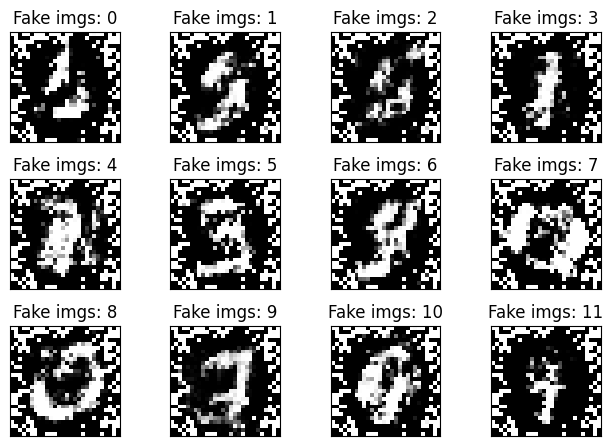

In [38]:
from matplotlib import pyplot as plt

def to_img(x):
    out = 0.5 * (x + 1)
    out = (out.clamp(0, 1)*256).to(torch.int32)
    out = out.view(-1, 28, 28)
    return out

imgs = to_img(fake_input)
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(imgs[i].detach().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Fake imgs: {i}")
    plt.xticks([])
    plt.yticks([])
plt.show()